# Logistic Regression Implementation

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from pandas_profiling import ProfileReport
from scipy import stats

import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from plotly.offline import iplot

import pickle

%matplotlib inline

C:\Users\Admin\AppData\Local\Temp\ipykernel_10996\4028759930.py:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
cf.go_offline()

# 1.0 Loading the "Diabetes" data

In [3]:
# Loading the "Diabetes" dataset

df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 2.0 Profiling the Data

## 2.1 Creating Profile Report

In [4]:
pr = ProfileReport(df)

### 2.1.1 Saving profile report locally

In [5]:
pr.to_file("diabetes_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 3.0 Exploratory Data Analysis

## 3.1 Inspecting features data types

In [6]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

## 3.2 Loading the "widget" form of the profile report

In [7]:
pr.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.3 Extracting features from the dataset

In [8]:
# Extracting features from the dataset

X = df.drop(columns = ['Outcome'])
X.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


## 3.4 Inspecting Correlation between features

### 3.4.1 Plotting Correlation Heatmap

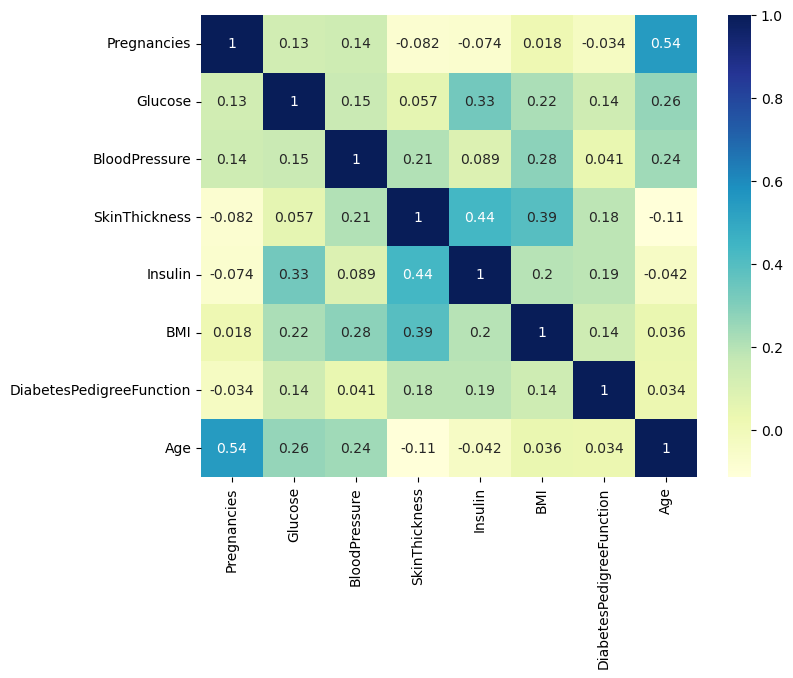

In [9]:
# Setting plot dimensions
fig = plt.figure()
fig.set_size_inches(8, 6)

# Plotting Correlation Heatmap
sns.heatmap(X.corr(), annot=True, cmap="YlGnBu")
plt.show()

### 3.4.2 Observation

As such, we're having no such features having strong correlation that we need to drop them.

## 3.5 Fixing Inconsistencies in Data

From analyzing the profile report, we got to know that we have some inconsistent features viz. 

- Pregnancies having 111 (14.5%) zeros
- BloodPressure having 35 (4.6%) zeros
- SkinThickness having 227 (29.6%) zeros
- Insulin having 374 (48.7%) zeros
- BMI having 11 (1.4%) zeros

Above features are inconsistent, as such it's advisable to fix these inconsistencies (zeroes) via **imputation** i.e replacing them with mean, median, or mode. Having said that, we know that most of the data is skewed, so it's better to go ahead with median instead of mean.

In [10]:
# Having again a bird-eye view of our dataset

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [11]:
# Friggin' features we have

df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## 3.6 Imputation by "Median"

In [12]:
# Imputing the missing vals with median 

df['Glucose'].replace(0, df['Glucose'].median(), inplace=True)

In [13]:
# Creating a fucntion to do the same for other features

def replace_zeroes(data, col):
    data[col].replace(0, data[col].mean(), inplace=True)

In [14]:
replace_zeroes(data=df, col='BloodPressure')
replace_zeroes(data=df, col='SkinThickness')
replace_zeroes(data=df, col='Insulin')
replace_zeroes(data=df, col='BMI')

## 3.7 Handling Outliers

### 3.7.1 Plot an interactive boxplot to visualize errors 

In [15]:
# Plotting a box plot to visualize outliers via "Cufflinks"

df.iplot(kind='box')

### 3.7.2 Plot a boxplot to visualize errors

<AxesSubplot:>

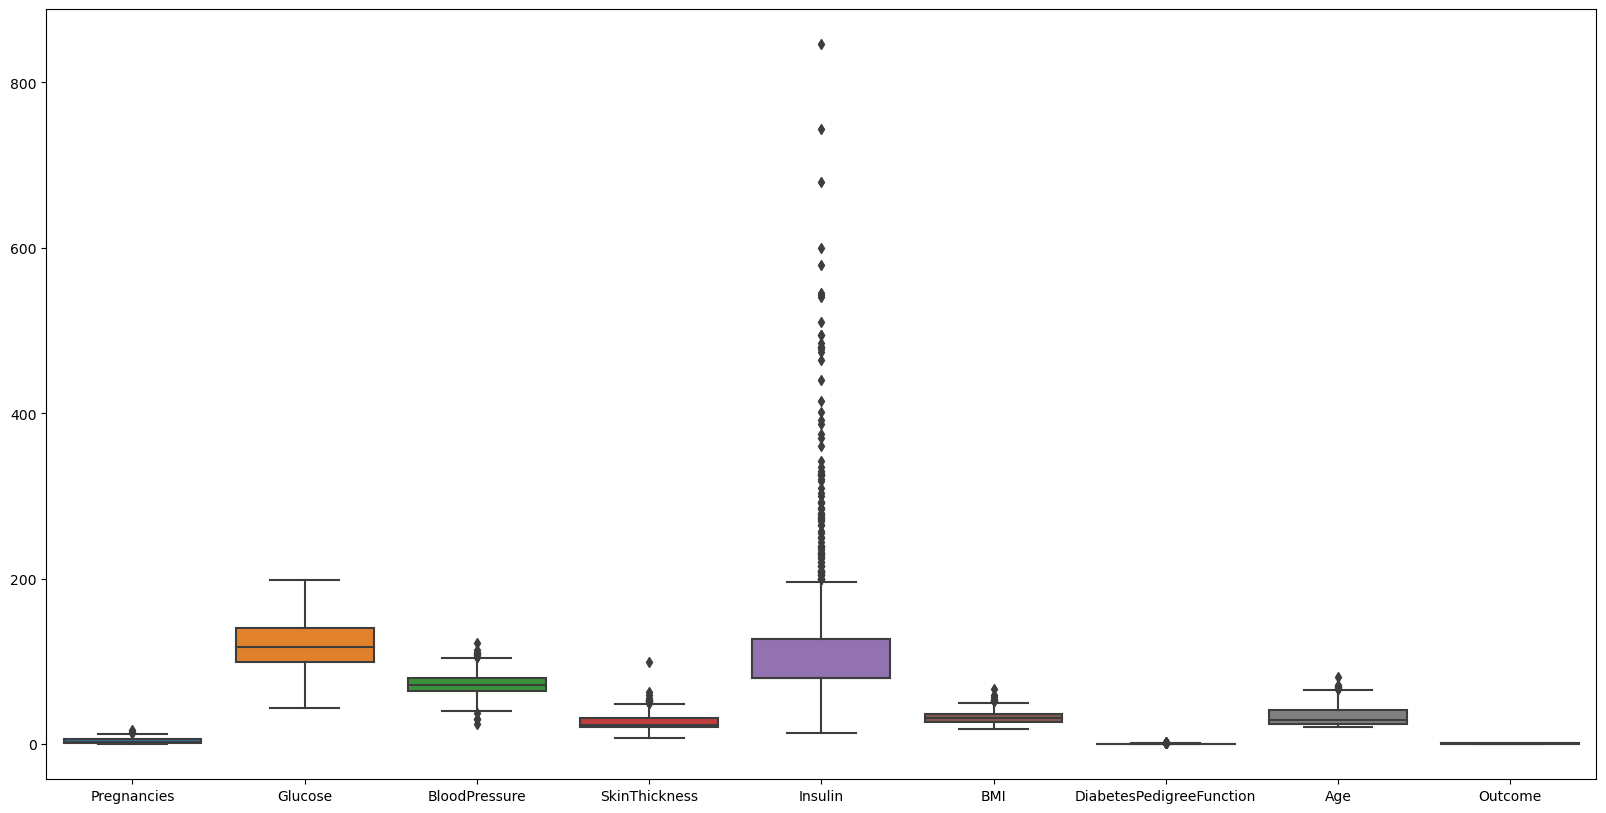

In [16]:
fig = plt.subplots(figsize = (20, 10))
sns.boxplot(data = df)

### 3.7.3 Prepare a deep copy of this corrected dataset

In [17]:
# Preparing a deep copy of this corrected dataset

df_new = df.copy(deep=True)
df_new.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137,40.0,35.000000,168.000000,43.1,2.288,33,1


### Quantile:

* **Quantiles are basically the values that split sorted data or a probability distribution into equal parts.**
* **q-quantile** will divide the sorted data into **q equal parts**.

**Note:** `df.quantile()` is finding the percentiles only. Don't fucking let it get you by its name.

### 3.7.4 Removing Outliers manually via 'Quantiles Inspection'

In [18]:
q = df['Pregnancies'].quantile(.98) # 12.0 i.e. 98 percentile value!
print(q)
df_new = df_new[df_new['Pregnancies'] < q]
      
q = df['BloodPressure'].quantile(.98) 
df_new = df_new[df_new['BloodPressure'] < q]
q = df['BloodPressure'].quantile(.22) 
df_new = df_new[df_new['BloodPressure'] > q]

q = df['SkinThickness'].quantile(.98) 
df_new = df_new[df_new['SkinThickness'] < q]

q = df['BMI'].quantile(.98) 
df_new = df_new[df_new['BMI'] < q]

q = df['DiabetesPedigreeFunction'].quantile(.9) 
df_new = df_new[df_new['DiabetesPedigreeFunction'] < q]

q = df['Age'].quantile(.98) 
df_new = df_new[df_new['Age'] < q]

# q = df['BloodPressure'].quantile(.97) 
# df_new = df_new[df_new['BloodPressure'] < q]

12.0


In [19]:
q = df['BloodPressure'].quantile(.97) 
df_new = df_new[df_new['BloodPressure'] < q]

<AxesSubplot:>

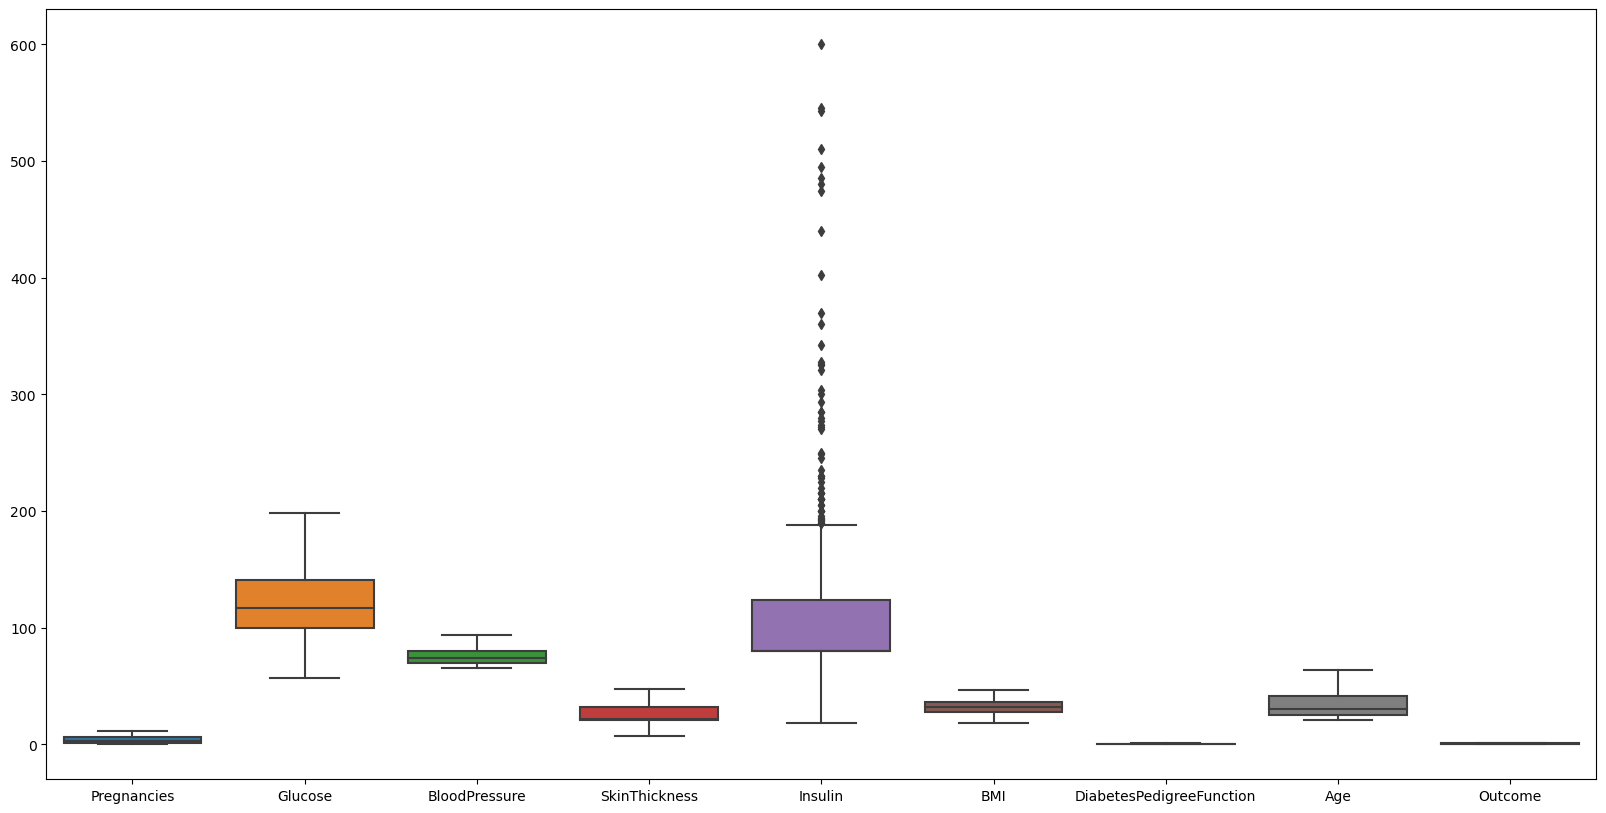

In [20]:
# Visulaizing the dataset after getting outliers handled

fig = plt.subplots(figsize = (20, 10))
sns.boxplot(data = df_new)

# 4.0 Separate features and labels

## 4.1 Features

In [21]:
# features we have

X = df_new.drop(columns = ['Outcome'])
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72.000000,35.000000,79.799479,33.6,0.627,50
1,1,85,66.000000,29.000000,79.799479,26.6,0.351,31
3,1,89,66.000000,23.000000,94.000000,28.1,0.167,21
5,5,116,74.000000,20.536458,79.799479,25.6,0.201,30
7,10,115,69.105469,20.536458,79.799479,35.3,0.134,29
...,...,...,...,...,...,...,...,...
758,1,106,76.000000,20.536458,79.799479,37.5,0.197,26
761,9,170,74.000000,31.000000,79.799479,44.0,0.403,43
764,2,122,70.000000,27.000000,79.799479,36.8,0.340,27
765,5,121,72.000000,23.000000,112.000000,26.2,0.245,30


## 4.2 Labels

In [22]:
# labels we've got

y = df_new['Outcome']
y

0      1
1      0
3      0
5      0
7      0
      ..
758    0
761    1
764    0
765    0
767    0
Name: Outcome, Length: 439, dtype: int64

# 5.0 Data Transformation

## 5.1 Applying boxcox transformation to the "Insulin" feature

In [23]:
# Boxcoxing the `Insulin` feature

insulin_boxcoxed, lambdA = stats.boxcox(df_new['Insulin'])
print(lambdA)
insulin_boxcoxed

-0.4165105758401917


array([2.01348942, 2.01348942, 2.03903545, 2.01348942, 2.01348942,
       2.226598  , 2.01348942, 2.01348942, 2.12156471, 2.01348942,
       2.15161832, 2.01348942, 2.04219475, 2.1538413 , 2.01348942,
       2.01348942, 2.01348942, 2.0996695 , 2.06818508, 2.01348942,
       2.09435816, 2.01348942, 2.01348942, 2.15809252, 2.01348942,
       2.01348942, 2.01348942, 2.01348942, 2.01348942, 2.01348942,
       2.01348942, 2.01348942, 2.01348942, 2.01348942, 2.01785402,
       1.75047038, 2.17773407, 2.18958687, 2.17896183, 2.01348942,
       2.01348942, 2.01348942, 2.01348942, 2.01348942, 2.01348942,
       1.87321121, 2.04824217, 2.03242165, 2.16772267, 2.01348942,
       2.01348942, 2.01348942, 2.01348942, 2.01348942, 2.01348942,
       1.99417028, 2.01348942, 2.07954168, 1.99417028, 2.01348942,
       2.12222687, 1.92213793, 2.01348942, 1.97620075, 2.15070987,
       1.88436527, 1.86119308, 2.08967947, 1.86731718, 2.01348942,
       2.01348942, 1.93407568, 2.04824217, 2.01348942, 2.08967

<AxesSubplot:>

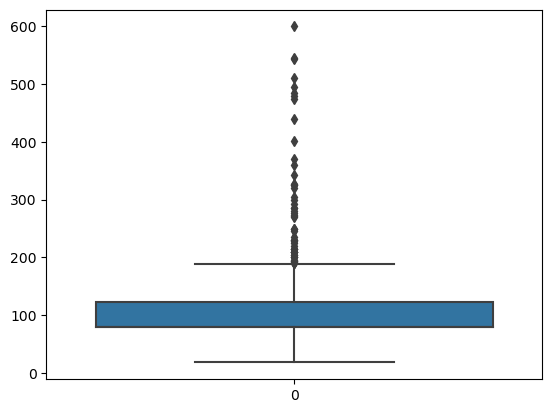

In [24]:
sns.boxplot(data = X['Insulin'])

<AxesSubplot:>

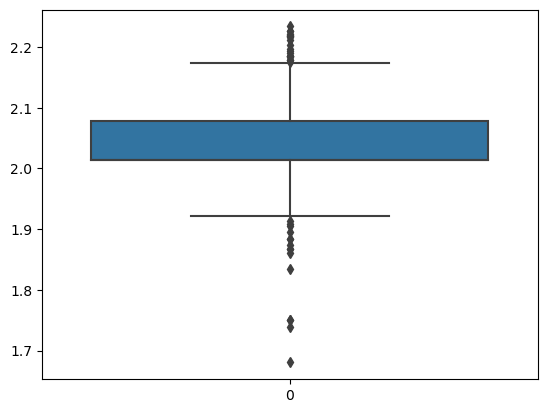

In [25]:
sns.boxplot(data=insulin_boxcoxed)

## 5.2 Applying logarithmic transformation to the "Insulin" feature

<AxesSubplot:>

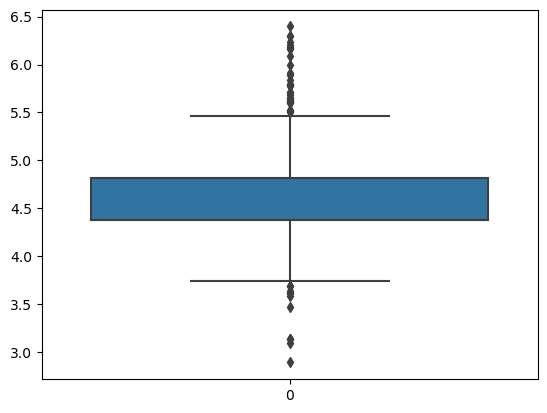

In [26]:
sns.boxplot(data = np.log(X['Insulin']))

## 5.3 Applying square-root transformation to the "Insulin" feature

<AxesSubplot:>

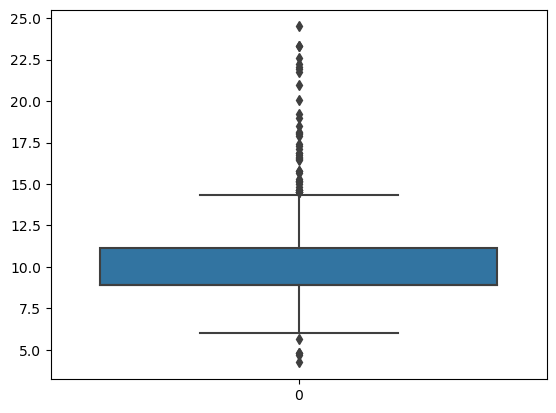

In [27]:
sns.boxplot(data = np.sqrt(X['Insulin']))

## 5.4 Verdict 

BoxCoxed Insulin is showing the best results among the lot!

In [28]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72.000000,35.000000,79.799479,33.6,0.627,50
1,1,85,66.000000,29.000000,79.799479,26.6,0.351,31
3,1,89,66.000000,23.000000,94.000000,28.1,0.167,21
5,5,116,74.000000,20.536458,79.799479,25.6,0.201,30
7,10,115,69.105469,20.536458,79.799479,35.3,0.134,29


In [29]:
X['Insulin'] = insulin_boxcoxed

In [30]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72.000000,35.000000,2.013489,33.6,0.627,50
1,1,85,66.000000,29.000000,2.013489,26.6,0.351,31
3,1,89,66.000000,23.000000,2.039035,28.1,0.167,21
5,5,116,74.000000,20.536458,2.013489,25.6,0.201,30
7,10,115,69.105469,20.536458,2.013489,35.3,0.134,29
...,...,...,...,...,...,...,...,...
758,1,106,76.000000,20.536458,2.013489,37.5,0.197,26
761,9,170,74.000000,31.000000,2.013489,44.0,0.403,43
764,2,122,70.000000,27.000000,2.013489,36.8,0.340,27
765,5,121,72.000000,23.000000,2.064502,26.2,0.245,30


<AxesSubplot:>

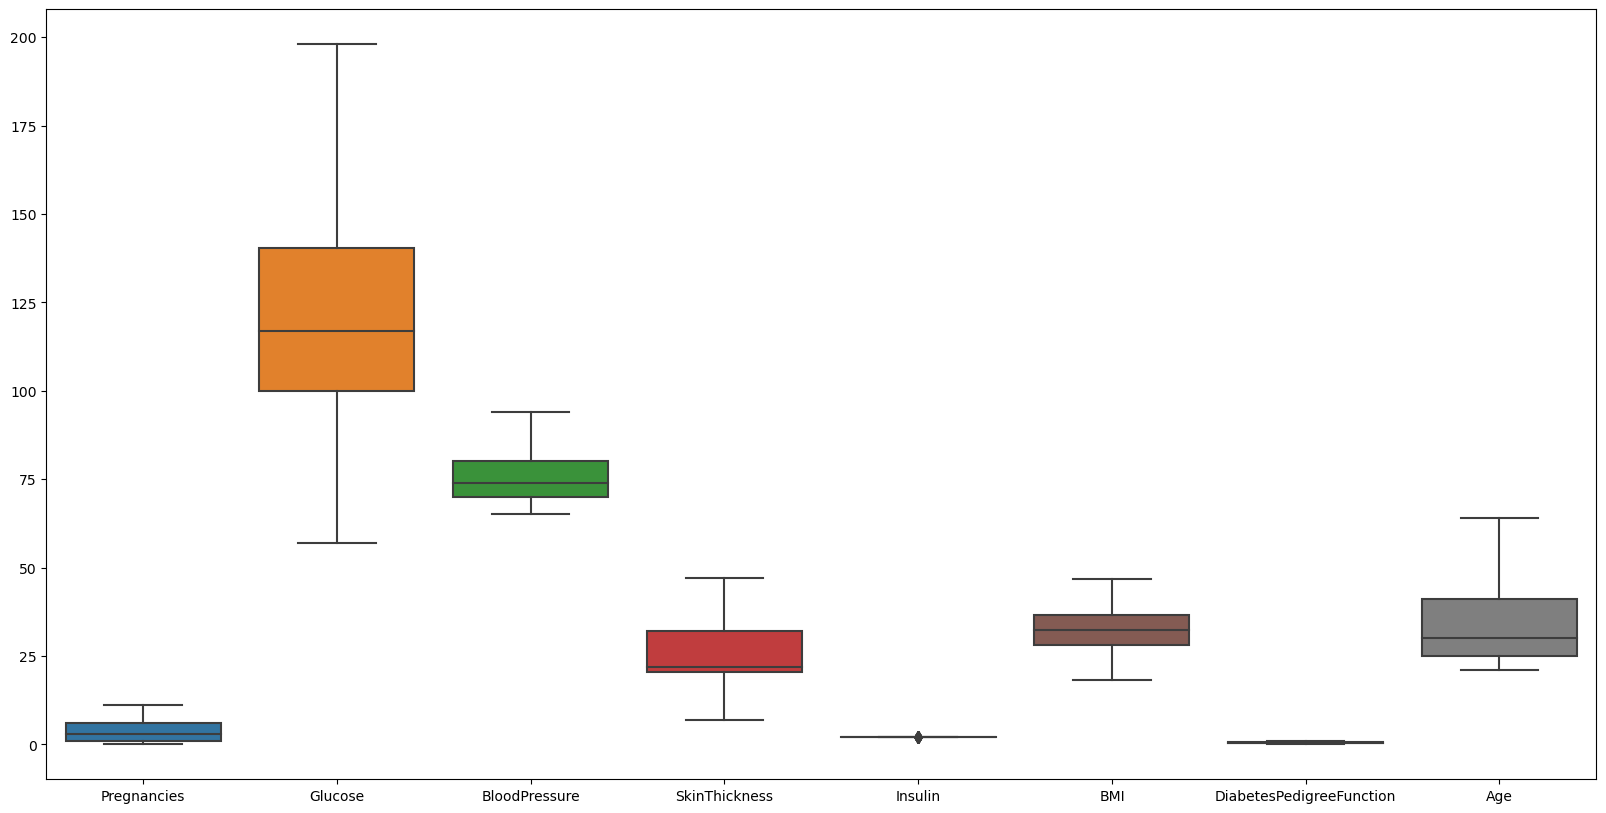

In [31]:
fig = plt.subplots(figsize = (20, 10))
sns.boxplot(data = X)

# 6.0 Handling Outliers via IQR (Inter Quartile Range) approach

## 6.1 Create a custom function to deal with outliers

In [32]:
# Creating a custom function that replaces the outliers with "NaN"

def outlier_removal(data):
    def outlier_limits(col):
        Q3, Q1 = np.nanpercentile(col, [75,25])
        IQR= Q3-Q1
        UL= Q3+1.5*IQR
        LL= Q1-1.5*IQR
        return UL, LL

    for column in data.columns:
        if data[column].dtype != 'int64':
            UL, LL= outlier_limits(data[column])
            data[column]= np.where((data[column] > UL) | (data[column] < LL), np.nan, data[column])

    return data

In [33]:
df_new.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## 6.2 Create a new copy of dataset having outliers dealt by this approach

In [34]:
# Creating a new copy of dataset having outliers deatl with the above approach

df_new2 = outlier_removal(df)
df_new2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137,40.0,35.000000,168.000000,43.1,NaN,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76.0,48.000000,180.000000,32.9,0.171,63,0
764,2,122,70.0,27.000000,79.799479,36.8,0.340,27,0
765,5,121,72.0,23.000000,112.000000,26.2,0.245,30,0
766,1,126,60.0,20.536458,79.799479,30.1,0.349,47,1


In [35]:
df_new2[df_new2['Insulin'].isnull().values]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
8,2,197,70.0,45.0,NaN,30.5,0.158,53,1
13,1,189,60.0,23.0,NaN,30.1,0.398,59,1
16,0,118,84.0,47.0,NaN,45.8,0.551,31,1
20,3,126,88.0,41.0,NaN,39.3,0.704,27,0
31,3,158,76.0,36.0,NaN,31.6,0.851,28,1
...,...,...,...,...,...,...,...,...,...
713,0,134,58.0,20.0,NaN,26.4,0.352,21,0
715,7,187,50.0,33.0,NaN,33.9,0.826,34,1
721,1,114,66.0,36.0,NaN,38.1,0.289,21,0
748,3,187,70.0,22.0,NaN,36.4,0.408,36,1


## 6.3 Drop the records containing null values (which were previously outliers)

In [36]:
# Dropping the records which were earlier outliers

X_new2 = df_new2.drop(columns=['Outcome'])
Y_new2= df_new2[['Outcome']]

In [37]:
X_new2.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [38]:
X_new2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72.0,35.000000,79.799479,33.6,0.627,50
1,1,85,66.0,29.000000,79.799479,26.6,0.351,31
2,8,183,64.0,20.536458,79.799479,23.3,0.672,32
3,1,89,66.0,23.000000,94.000000,28.1,0.167,21
4,0,137,40.0,35.000000,168.000000,43.1,NaN,33


## 6.4 Impute these new missing records (previously outliers) via "median"

In [39]:
# Creating a custom function to impute these new missing records

def impute_them_all(X):
    
    def impute(X, col):
        X[col].mask(X[col].isnull(), X[col].median(), inplace=True)
    
    for i in X.columns:
        impute(X=X, col=i)

In [40]:
impute_them_all(X=X_new2)

## 6.5 Visualize the features after getting outliers dealt via this new approach

<AxesSubplot:>

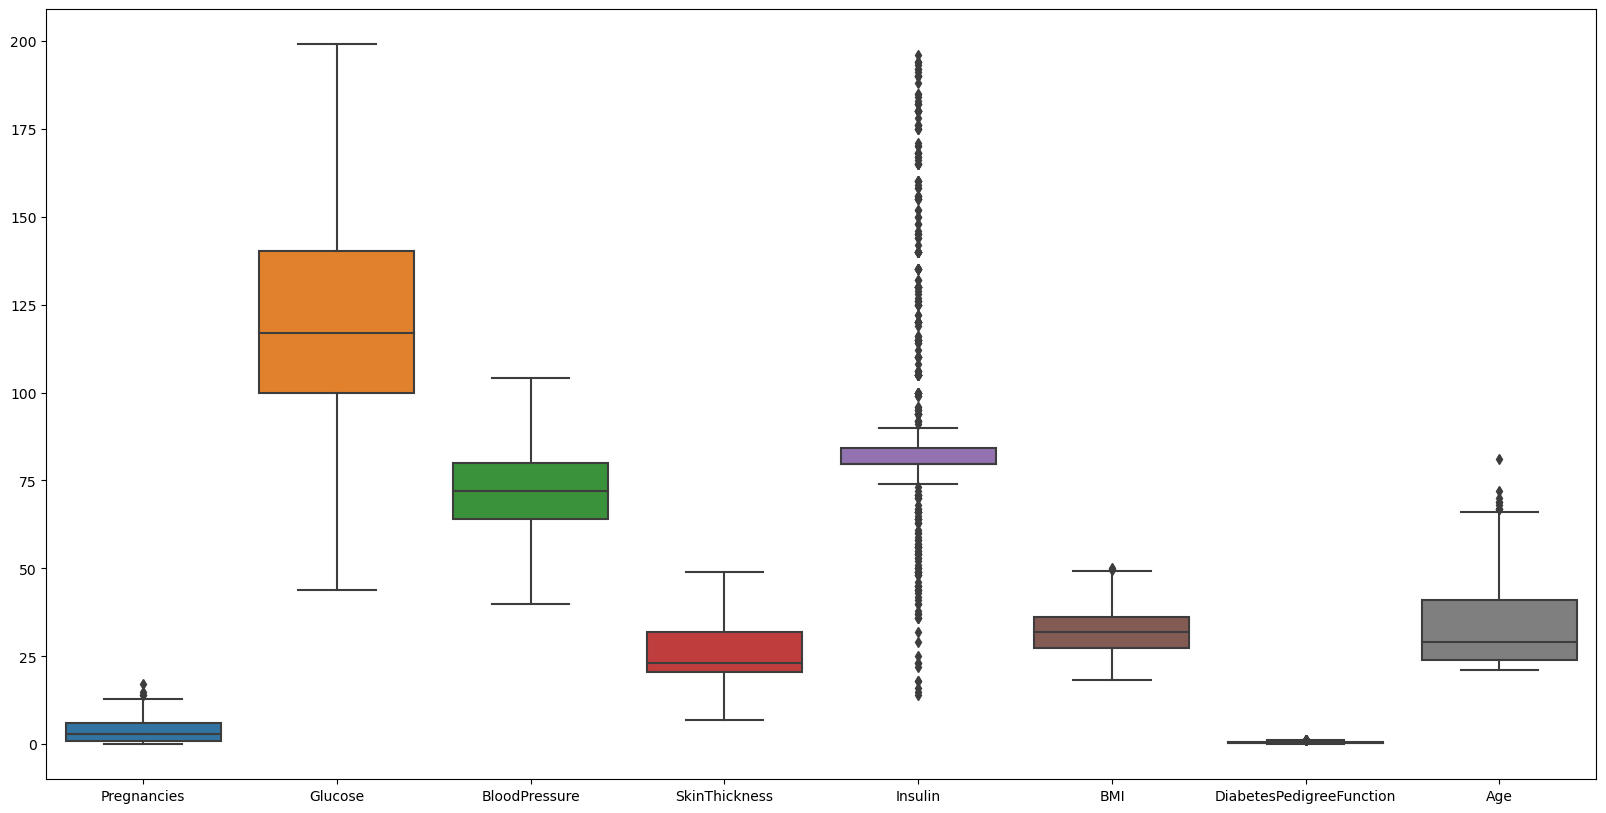

In [41]:
# Visualizing the features after dealing eith outliers

plt.fig, ax = plt.subplots(figsize = (20, 10))
sns.boxplot(data = X_new2, ax=ax)

## 6.6 Verdict 

Gotta **roll back** to earlier approach, the one where we manually dealt with outliers and applied boxcox transformation.

# 7.0 Standardization

## 7.1 Standardization of features via Standard Scaling technique

In [42]:
# Applying Standard Scaling to the features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.68685931,  0.88647859, -0.52360762, ...,  0.20246007,
         1.16417471,  1.53945405],
       [-0.9360214 , -1.24602017, -1.34691951, ..., -0.94340796,
        -0.18399275, -0.24099329],
       [-0.9360214 , -1.11062343, -1.34691951, ..., -0.69786481,
        -1.08277105, -1.17807084],
       ...,
       [-0.61144526,  0.00639973, -0.79804492, ...,  0.72628545,
        -0.23772406, -0.61582431],
       [ 0.36228316, -0.02744945, -0.52360762, ..., -1.00888614,
        -0.7017672 , -0.33470105],
       [-0.9360214 , -0.97522668, -0.79804492, ..., -0.32136532,
        -0.35984067, -0.99065533]])

## 7.2 Visualize the distribution of 'Scaled' features

In [43]:
# Visualizing the scaled features

pd.DataFrame(X_scaled, columns = X.columns).iplot(kind='hist', subplots=True)

## 7.3 Plot the box plot against the 'Scaled' features

<AxesSubplot:>

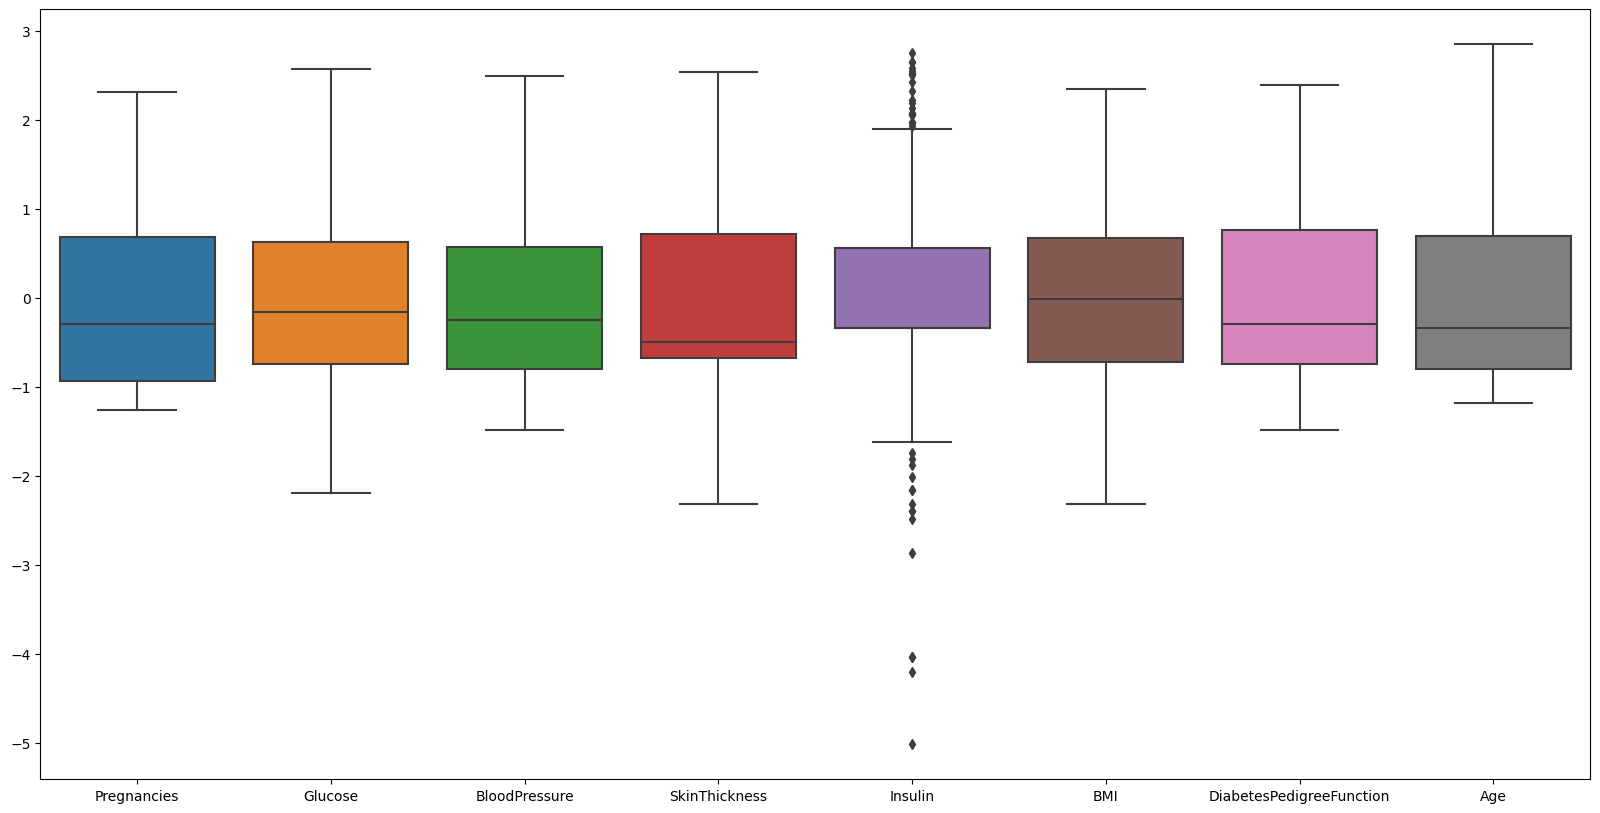

In [44]:
# Let's have a look at the retained outliers, lmao

plt.fig, ax = plt.subplots(figsize = (20, 10))
sns.boxplot(data = pd.DataFrame(X_scaled, columns = X.columns), ax=ax)

**=>** Friggin' stubborness of the **"Insulin"** feature.

## 7.3 Inspect Correlation Heatmap of the 'Scaled' features

In [45]:
pd.DataFrame(X_scaled, columns = X.columns)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.686859,0.886479,-0.523608,1.081467,-0.341411,0.202460,1.164175,1.539454
1,-0.936021,-1.246020,-1.346920,0.354271,-0.341411,-0.943408,-0.183993,-0.240993
2,-0.936021,-1.110623,-1.346920,-0.372926,0.017267,-0.697865,-1.082771,-1.178071
3,0.362283,-0.196695,-0.249170,-0.671506,-0.341411,-1.107103,-0.916692,-0.334701
4,1.985164,-0.230545,-0.920791,-0.671506,-0.341411,0.480742,-1.243965,-0.428409
...,...,...,...,...,...,...,...,...
434,-0.936021,-0.535187,0.025267,-0.671506,-0.341411,0.840872,-0.936231,-0.709532
435,1.660588,1.631161,-0.249170,0.596669,-0.341411,1.904893,0.070010,0.883500
436,-0.611445,0.006400,-0.798045,0.111872,-0.341411,0.726285,-0.237724,-0.615824
437,0.362283,-0.027449,-0.523608,-0.372926,0.374825,-1.008886,-0.701767,-0.334701


In [46]:
pd.DataFrame(X_scaled, columns = X.columns).corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.132374,0.068644,0.043875,0.064110,-0.015451,0.018086,0.551366
Glucose,0.132374,1.000000,0.133314,0.099743,0.414462,0.165580,0.063264,0.227949
BloodPressure,0.068644,0.133314,1.000000,0.111136,0.079159,0.193998,0.073538,0.192597
SkinThickness,0.043875,0.099743,0.111136,1.000000,0.325424,0.492675,0.064217,0.007851
Insulin,0.064110,0.414462,0.079159,0.325424,1.000000,0.230075,0.140598,0.125349
BMI,-0.015451,0.165580,0.193998,0.492675,0.230075,1.000000,0.063007,-0.018607
DiabetesPedigreeFunction,0.018086,0.063264,0.073538,0.064217,0.140598,0.063007,1.000000,0.051628
Age,0.551366,0.227949,0.192597,0.007851,0.125349,-0.018607,0.051628,1.000000


<AxesSubplot:>

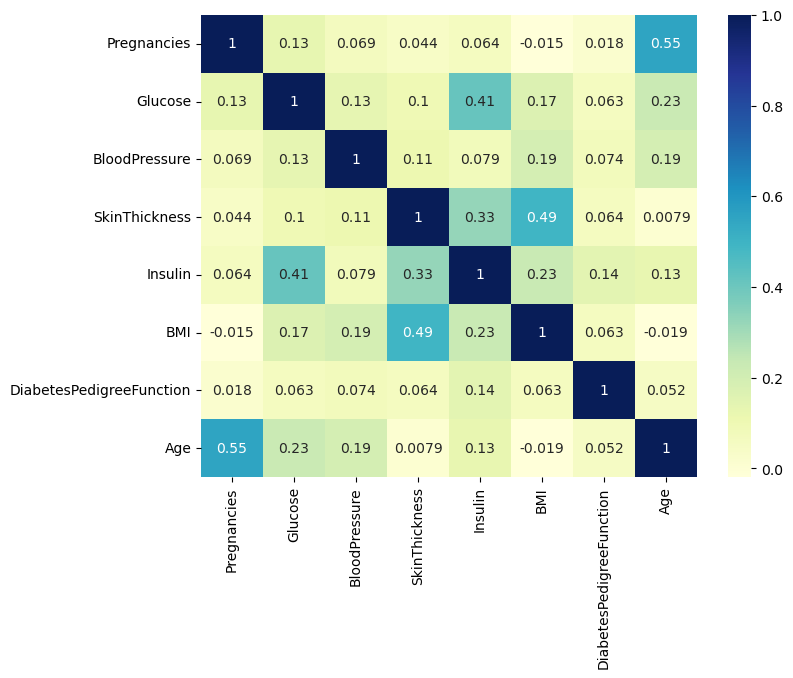

In [47]:
# Having a look at the correlation of our new transformed features

fig = plt.figure()
fig.set_size_inches(8, 6)
sns.heatmap(data = pd.DataFrame(X_scaled, columns = X.columns).corr(), cmap="YlGnBu", annot=True)

**=>** No worries here!

# 8.0 Train-Test split

In [48]:
# Performing train-test split

X_train, X_test, y_train , y_test = train_test_split(X_scaled, y, test_size=.20, random_state=42)

In [49]:
X_train

array([[-1.26059754,  0.51413753, -0.79804492, ...,  0.1369819 ,
        -1.06811705, -1.08436309],
       [ 1.33601159, -0.06129864,  0.29970426, ..., -1.20532066,
         0.09931781,  2.85136262],
       [-0.61144526, -1.71990879, -0.79804492, ..., -0.71423436,
         0.96390345, -1.08436309],
       ...,
       [-0.9360214 , -0.46748888,  1.67189074, ..., -0.86156025,
         0.05535582, -0.89694758],
       [ 1.66058773,  1.63116069, -0.24917033, ...,  1.90489257,
         0.07000982,  0.88349977],
       [ 0.68685931,  0.41258997, -0.79804492, ...,  0.49711185,
         0.74897821, -0.4284088 ]])

In [50]:
y_train

471    0
509    0
47     0
141    0
521    0
      ..
178    0
476    1
600    0
761    1
171    1
Name: Outcome, Length: 351, dtype: int64

# 9.0 Build a 'Logistic Regression' model

## 9.1 Does Logistic regression implement any Regularization modes?

Yes, it indeed does. It even implements all three regularization modes by itself based on the solver selected at hand.

## 9.2 For multi-classes classification i.e. 'multinomial' classification, which loss function is used?

**Categorical Cross-Entropy Loss** it is.

<img src="./Screenshot (299).png" alt="Image" width="600"/>

**Note:** Currently the `multinomial` option is supported only by the `lbfgs`, `sag`, `saga` and `newton-cg` solvers.

- `liblinear` solver can't be used for multi-class classification.
<br><br>
- For small datasets, `liblinear` is a good choice, whereas `sag` and `saga` are faster for large ones.
<br><br>
- For multiclass problems, only `newton-cg`, `sag`, `saga` and `lbfgs` handle multinomial loss.
<br><br>
- `liblinear` is limited to one-versus-rest schemes.

As such, the choice of the algorithm depends on the penalty chosen. Supported penalties are:

- `newton-cg` - [‘l2’, ‘none’]
<br><br>
- `lbfgs` - [‘l2’, ‘none’]
<br><br>
- `liblinear` - [‘l1’, ‘l2’]
<br><br>
- `sag` - [‘l2’, ‘none’]
<br><br>
- `saga` - [‘elasticnet’, ‘l1’, ‘l2’, ‘none’]

## 9.2 Build the model

In [51]:
# Building the 'Logistic Regression' model

log_r = LogisticRegression(verbose=1)
log_r

LogisticRegression(verbose=1)

In [52]:
# Fitting the model to our training features and labels

log_r.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(verbose=1)

### 9.2.1 Model Evaluation using the "Accuracy" metric

In [53]:
# Model Evaluation on training set

log_r.score(X_train, y_train)*100

78.34757834757835

In [54]:
# Model Evaluation on test set

log_r.score(X_test, y_test)*100

71.5909090909091

## 9.3 Build the model using the 'liblinear' solver

In [55]:
log_libl = LogisticRegression(verbose=1, solver='liblinear')
log_libl

LogisticRegression(solver='liblinear', verbose=1)

In [56]:
log_libl.fit(X_train, y_train)

[LibLinear]

LogisticRegression(solver='liblinear', verbose=1)

### 9.3.1 'liblinear' Model Evaluation using the "Accuracy" metric

In [57]:
log_libl.score(X_test, y_test)*100

71.5909090909091

# 10.0 Evaluation of the above classifiers

In [58]:
y_pred = log_r.predict(X_test)
y_pred

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0],
      dtype=int64)

In [59]:
y_pred_libl = log_libl.predict(X_test)
y_pred_libl

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0],
      dtype=int64)

In [60]:
confusion_matrix(y_test, y_pred)

array([[48,  6],
       [19, 15]], dtype=int64)

In [61]:
confusion_matrix(y_test, y_pred_libl)

array([[48,  6],
       [19, 15]], dtype=int64)

In [62]:
# Creating a custom function to compute classification performance metrics

def model_eval(y_true, y_pred):
    tp, fp, fn, tn =  confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = (tp+tn)/(tp+fp+fn+tn)
    sensitivity = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1 = 2*precision*sensitivity/(precision+sensitivity)
    specificity = tn/(tn+fp)
    
    return {'accuracy': accuracy, 
            'sensitivity': sensitivity, 
            'precision': precision, 
            'f1': f1, 
            'specificity': specificity
           }

In [63]:
model_eval(y_test, y_pred)

{'accuracy': 0.7159090909090909,
 'sensitivity': 0.7164179104477612,
 'precision': 0.8888888888888888,
 'f1': 0.793388429752066,
 'specificity': 0.7142857142857143}

In [64]:
# for simple logistic classifier

auc = roc_auc_score(y_test, y_pred)
auc

0.6650326797385621

In [65]:
# for 'liblinear' logistic classifier

auc_libl = roc_auc_score(y_test, y_pred_libl)
auc_libl

0.6650326797385621

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(fpr, tpr, thresholds)

[0.         0.11111111 1.        ] [0.         0.44117647 1.        ] [2 1 0]


In [67]:
fpr_libl, tpr_libl, thresholds_libl = roc_curve(y_test, y_pred)
print(fpr_libl, tpr_libl, thresholds_libl)

[0.         0.11111111 1.        ] [0.         0.44117647 1.        ] [2 1 0]


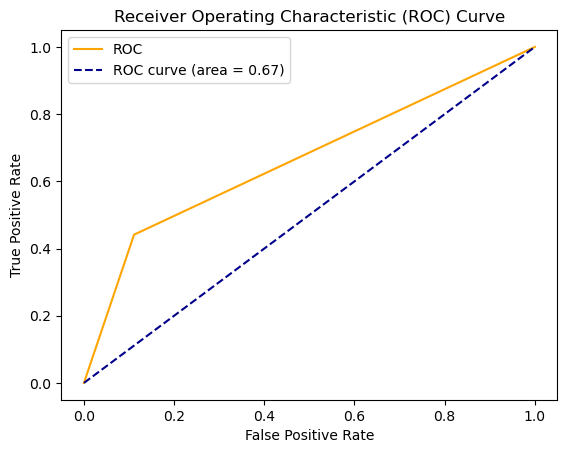

In [68]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

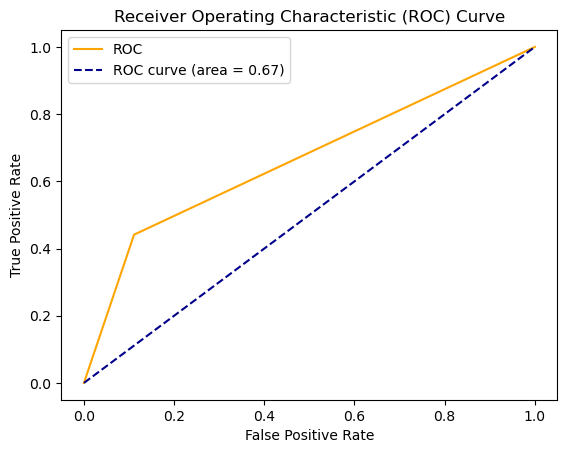

In [69]:
plt.plot(fpr_libl, tpr_libl, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()